## TP2 KNN

Pereira Alban - Gayraud Laurent - BGD

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import neighbors, model_selection
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tp2_source import *

### Génération artificielle de données

<img src="questions/1.png" alt="question 1" width="800"/>

In [2]:
# Génération de données avec 2 classes avec rand_bi_gauss, rand_clown, rand_checkers
# pour différentes valeurs de n, sigma et mu

d1 = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],sigmas2=[0.9, 0.9])

d2 = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1],sigma1=[0.9, 0.9],sigma2=[0.9, 0.9],sigma3=[0.9, 0.9])

d3 = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

d4 = rand_checkers(n1=150, n2=150)

1- La fonction rand_bi_gauss génère deux échantillons de taille n1 et n2 suivant des lois gaussiennes centrée en mu1 et mu2 avec des déviations standard sigma1 et sigma2. Cette fonction retourne deux éléments : un tableau de point X avec des coordonnées en deux dimensions (de taille n1 + n2) et un tableau de label y avec des valeurs égales à 1 ou -1 pour labeliser chaque point selon son groupe de départ.
  
2- La fonction rand_tri_gauss a les mêmes fonctions mais pour trois groupes de points.  
  
3- La fonction rand_clown génère un échantillon avec une forme parabolique induite par le x0^2 dans le code source et un deuxième échantillon suivant une loi normale. Cette fonction est supposée générer, pour un échantillon important, un sourire (induit par la parabolle) et des points au creux de la parabole d'où le terme "clown". Concernant le retour, nous obtenons X contenant un tableau de points, et y un tableau de labels avec des valeurs de 1 pour la fonction parabollique et -1 pour le nuage de points.

4- La fonction génène une ensemble de données en forme de damier (checkers en anglais). Elle retourne un tableau de points ainsi qu'un tableau de label.

<img src="questions/2.png" alt="question 2" width="800"/>

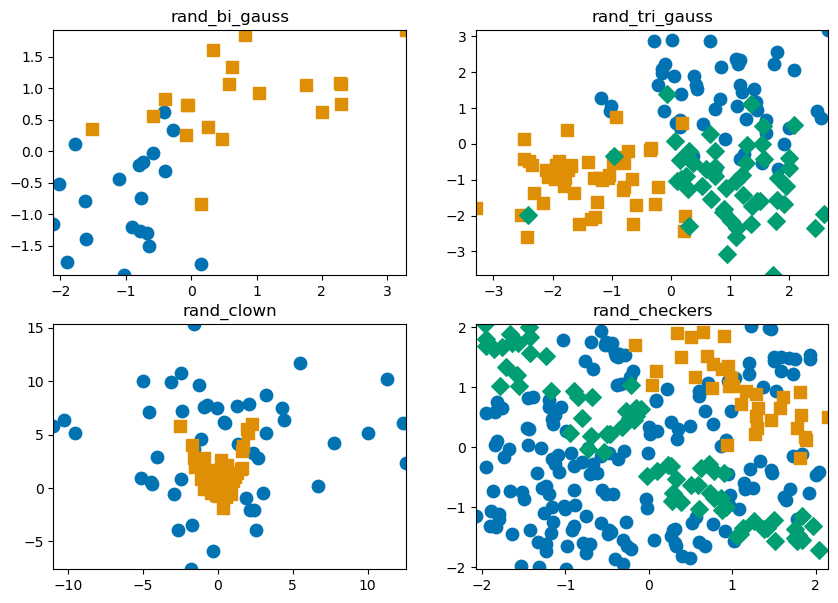

In [3]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.title("rand_bi_gauss")
plot_2d(d1[0], d1[1])

plt.subplot(2, 2, 2)
plt.title("rand_tri_gauss")
plot_2d(d2[0], d2[1])

plt.subplot(2, 2, 3)
plt.title("rand_clown")
plot_2d(d3[0], d3[1])

plt.subplot(2, 2, 4)
plt.title("rand_checkers")
plot_2d(d4[0], d4[1])

plt.show()

### Approche intuitive

<img src="questions/3.png" alt="question 3" width="800"/>

Pour effectuer une régression, une approche possible consiste à utiliser la méthode des k-plus proches voisins par rapport aux valeurs observées de la variable $y$. Pour chaque nouveau point $y$ que l'on souhaite estimer, on calcule sa distance par rapport à l'ensemble des observations de l'échantillon, généralement en utilisant une mesure comme la distance euclidienne. Cette opération nous permet d'obtenir l'ensemble $V_k(y)$ qui contient les k-plus proches voisins de $y$.

Cependant, contrairement à une classification où l'on pourrait simplement prendre la classe majoritaire parmi les k-plus proches voisins, dans le cas de la régression, $y$ est une variable continue. Par conséquent, au lieu de déterminer une classe majoritaire, on peut adapter la méthode en utilisant la valeur moyenne des k-plus proches voisins comme estimation de $y$ pour ce nouveau point. Il est même possible d'aller plus loin en utilisant une mesure de distance autre que la distance euclidienne ou en calculant une moyenne différente de la moyenne arithmétique pour estimer la valeur de $y$.

### Approche formelle

<img src="questions/4.png" alt="question 4" width="800"/>

In [4]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """Homemade kNN classifier class without using sklearn.neighbors"""
    
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        # Store the training data and labels
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X):
        # Make predictions for each element in X
        predictions = []
        for point in X:
            # Calculate distances from the current point to all training points
            distances = np.linalg.norm(self.X_train - point, axis=1)
            # Find the indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.n_neighbors]
            # Get the labels of the k nearest neighbors
            k_nearest_labels = self.y_train[k_indices]
            # Ensure the labels are integer type for np.bincount to work properly
            k_nearest_labels = k_nearest_labels.astype(int)
            # Determine the most common label (class) among the nearest neighbors
            most_common = np.argmax(np.bincount(k_nearest_labels))
            predictions.append(most_common)
        return np.array(predictions)

In [5]:
# Load dataset #2
X_d2, y_d2 = d2

# Splitting dataset for training and testing (pair for the training, impair for the testing)
X_train_d2, X_test_d2 = X_d2[::2], X_d2[1::2]
y_train_d2, y_test_d2 = y_d2[::2], y_d2[1::2]

# Custom KNN
homemade_knn = KNNClassifier(n_neighbors=5)
homemade_knn.fit(X_train_d2, y_train_d2)
homemade_predictions = homemade_knn.predict(X_test_d2)

# Scikit-learn KNN
sklearn_knn = KNeighborsClassifier(n_neighbors=5)
sklearn_knn.fit(X_train_d2, y_train_d2)
sklearn_predictions = sklearn_knn.predict(X_test_d2)

# Comparing accuracies
homemade_score = accuracy_score(y_test_d2, homemade_predictions)
sklearn_accuracy = accuracy_score(y_test_d2, sklearn_predictions)

# Plotting the results
print("Etiquettes de label pour KNN Homemade : \n", homemade_predictions)
print("Etiquettes de label pour KNN Scikit-learn : \n", sklearn_predictions)
print("Score pour KNN Homemade :", homemade_score)
print("Score pour KNN Scikit-learn :", sklearn_accuracy)

Etiquettes de label pour KNN Homemade : 
 [1 2 2 3 3 3 3 1 1 2 3 1 2 2 3 1 1 2 2 3 1 1 2 3 1 2 1 1 3 3 3 3 1 2 2 2 1
 1 3 3 3 1 1 3 2 1 1 2 1 1 1 2 1 3 2 2 1 3 1 1 3 3 2 3 1 1 2 1 3 2 1 3 2 1
 1]
Etiquettes de label pour KNN Scikit-learn : 
 [1. 2. 2. 3. 3. 3. 3. 1. 1. 2. 3. 1. 2. 2. 3. 1. 1. 2. 2. 3. 1. 1. 2. 3.
 1. 2. 1. 1. 3. 3. 3. 3. 1. 2. 2. 2. 1. 1. 3. 3. 3. 1. 1. 3. 2. 1. 1. 2.
 1. 1. 1. 2. 1. 3. 2. 2. 1. 3. 1. 1. 3. 3. 2. 3. 1. 1. 2. 1. 3. 2. 1. 3.
 2. 1. 1.]
Score pour KNN Homemade : 0.8266666666666667
Score pour KNN Scikit-learn : 0.8266666666666667


<img src="questions/5.png" alt="question 5" width="800"/>

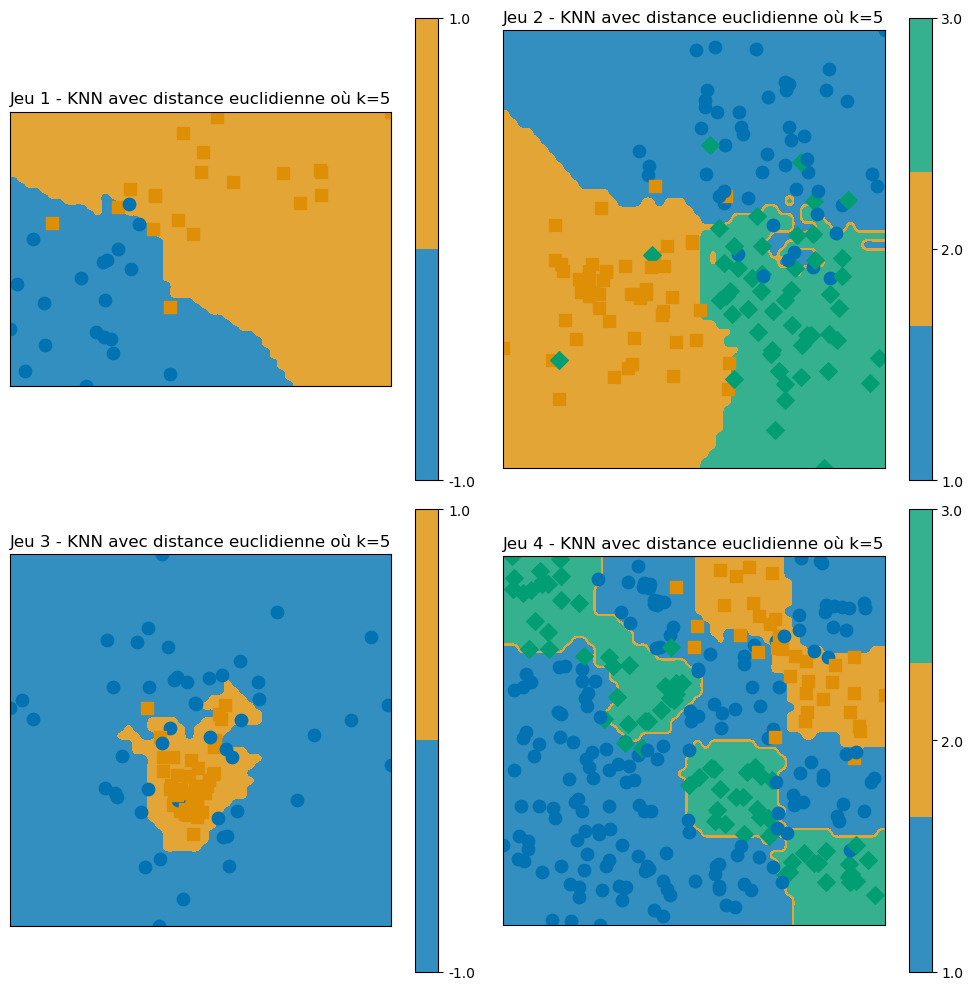

In [6]:
datasets = [d1, d2, d3, d4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, dataset in enumerate(datasets):
    X, y = dataset # Extract features and labels from each dataset
    knn = KNeighborsClassifier(n_neighbors=5) # Initialize and train KNN classifier
    knn.fit(X, y)
    
    plt.sca(axes[i // 2, i % 2]) # Select subplot based on the dataset index. 'i // 2' determines the row, and 'i % 2' the column
    decision_function = lambda x: knn.predict(x.reshape(1, -1)) # Plot the decision boundaries
    frontiere_new(decision_function, X, y, step=50, alpha_choice=1)
    plt.title(f'Jeu {i+1} - KNN avec distance euclidienne où k=5')

plt.tight_layout()
plt.show()

<img src="questions/6.png" alt="question 6" width="800"/>

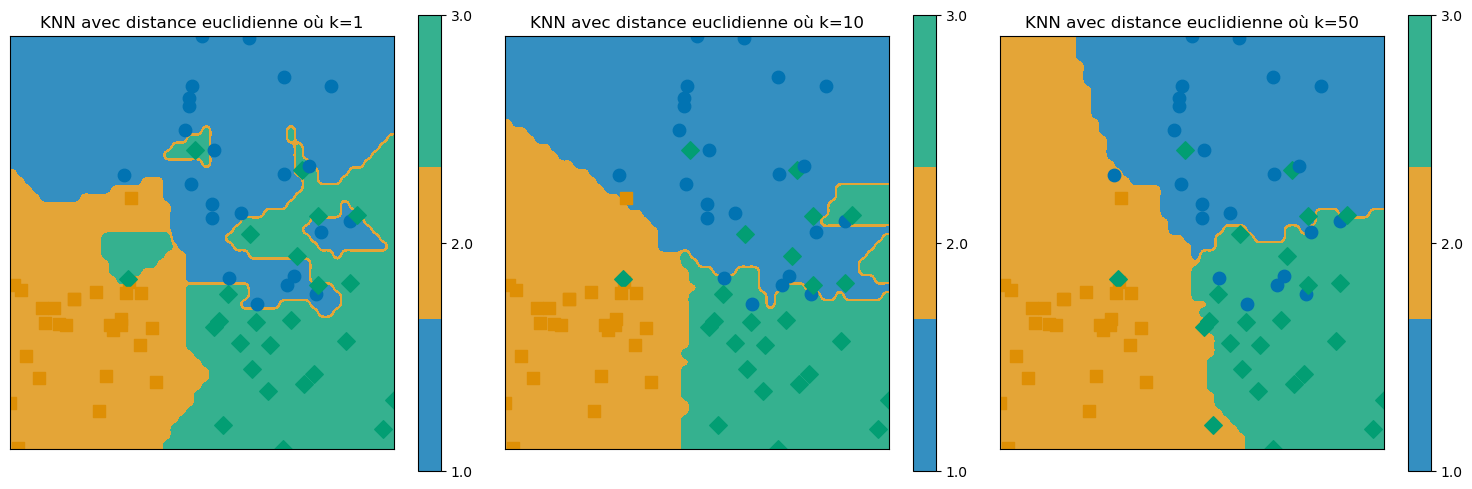

Accuracy score for k=1: 0.73
Accuracy score for k=10: 0.87
Accuracy score for k=50: 0.88


In [7]:
# d2 dataset is already splitted into training and testing sets

# Values of k to test
k_values = [1, 10, 50]

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop over different values of k
for i, k in enumerate(k_values):
    # Initialize and train KNN classifier with current k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_d2, y_train_d2)
    
    # Select subplot
    plt.sca(axes[i])
    
    # Decision function for plotting
    decision_function = lambda x: knn.predict(x.reshape(1, -1))
    
    # Plot the decision boundaries
    frontiere_new(decision_function, X_train_d2, y_train_d2, step=50, alpha_choice=1)
    plt.title(f"KNN avec distance euclidienne où k={k}")

plt.tight_layout()
plt.show()

# Bonus : Accuracy scores for different values of k to show the impact on the accuracy
scores = []

for k in k_values:
    # Initialize and train KNN classifier with current k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_d2, y_train_d2)
    
    # Get predictions for the testing set
    predictions = knn.predict(X_test_d2)
    
    # Calculate accuracy score and append to scores list
    scores.append(accuracy_score(y_test_d2, predictions))

# Print scores
for k, score in zip(k_values, scores):
    print(f"Accuracy score for k={k}: {score.round(2)}")


 $\underline{Commentaire}$ : La frontière de décision est logiquement plus précise (simple) en augmentant le nombre de plus proches voisins pris en compte.  
 Pour le cas k=1, ces frontières sont complexes et perméables. Plusieurs zones isolées apparaissent là on s'y attendrait pas forcément et ces zones sont peu nettes puisqu'il n'y a pas de lignes droites pour séparer les labels. On pourrait voir ici une analogie de l'overfitting pour de petites valeurs avec des frontières de décision très complexes.    
   
 Il est bon de noter que pour k=50, cela génère plus d'erreurs de labellisation pour le présent jeu de données que pour k=10. Augmenter la valeur de k n'est donc pas synonyme d'amélioration de la précision de prédiction car cela simplifie trop fortement les frontières de décision. L'affichage des scores d'accuracy permet de mettre ce fait en valeur.

<img src="questions/7.png" alt="question 7" width="800"/>

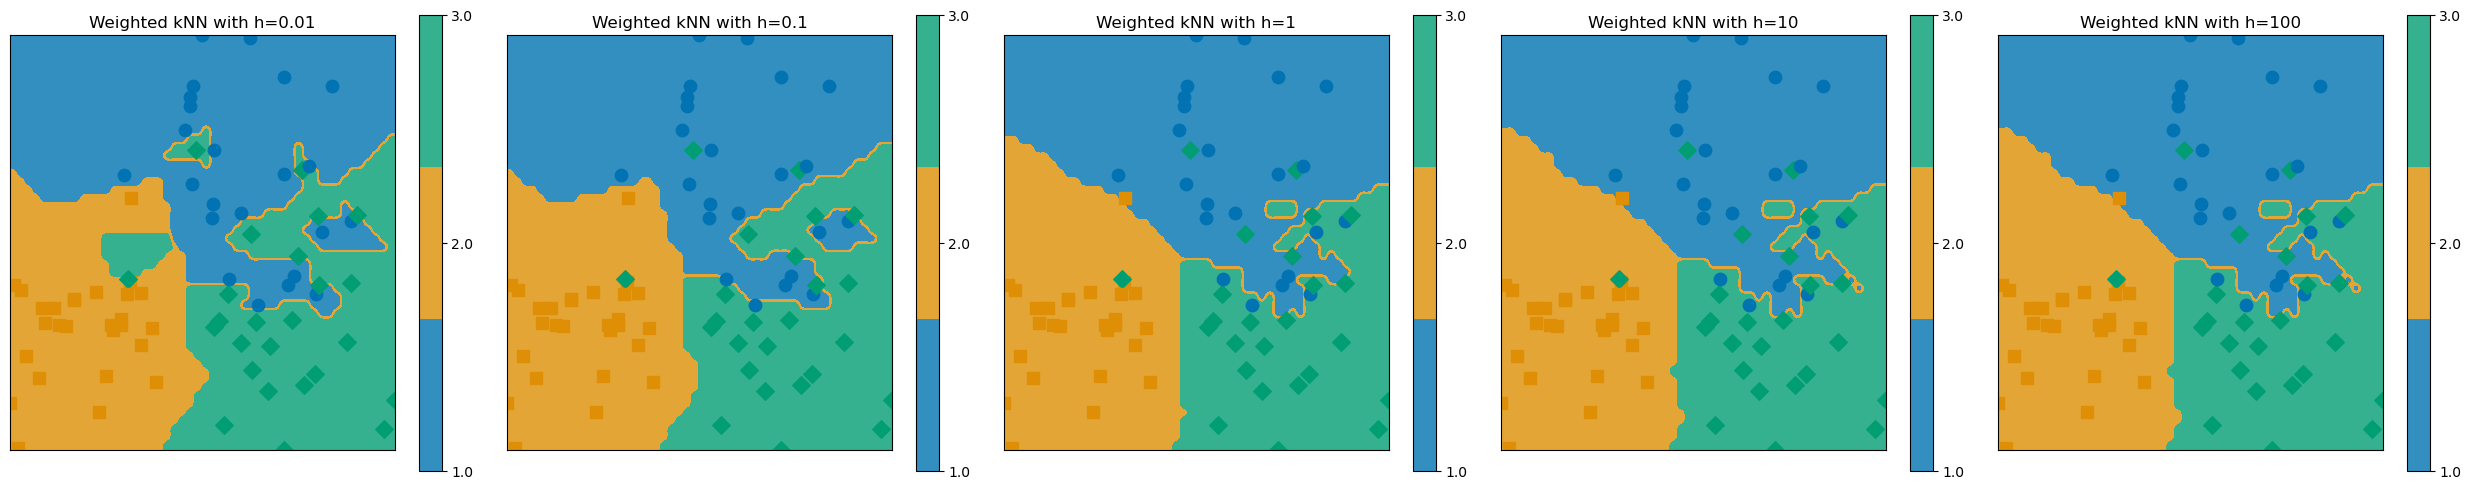

In [8]:
# Implementing weighted KNN with weights parameter

# Define the weight function based on the exponential decay formula
def weight_func(distances, h):
    return np.exp(-(distances ** 2) / h)

# Creating subplots for each value of h
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # Adjust the size as needed

# Visualization for each h
for i, h in enumerate([10**j for j in range(-2, 3)]):
    knn = KNeighborsClassifier(n_neighbors=7, weights=lambda d: weight_func(d, h))
    knn.fit(X_train_d2, y_train_d2)

    # Select subplot
    plt.sca(axes[i])
    
    # Decision function for plotting
    decision_function = lambda x: knn.predict(x.reshape(1, -1))
    
    # Plot the decision boundaries
    frontiere_new(decision_function, X_train_d2, y_train_d2, step=50, alpha_choice=1)

    plt.title(f"Weighted kNN with h={h}")

plt.tight_layout()
plt.show()

 $\underline{Commentaire}$ : En fixant la valeur de k à 7, des valeurs de h petites permettent de mettre un poids important sur les voisins immédiats, ce qui peut conduire à des frontières de décision complexes (pour de petites valeurs de h, l'exponentielle (-d^2/h) diminue rapidement avec la distance).

Des valeurs de h plus grandes permettent permettent de donner un poids équitable à un plus grand nombre de voisins, ce qui conduit à des frontières de décision plus lisses et plus simples (pour de grandes valeurs de h, l'exponentielle (-d^2/h) diminue lentement avec la distance).

<img src="questions/8.png" alt="question 8" width="800"/>

In [9]:
# METHODE CLASSIQUE

# Initialize the kNN classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1)

# Train the classifier on the training data
knn.fit(X_train_d2, y_train_d2)

# Predict on the training data
train_predictions = knn.predict(X_train_d2)

# Predict on the test data
test_predictions = knn.predict(X_test_d2)

# Calculate accuracy on training data
train_accuracy = accuracy_score(y_train_d2, train_predictions)

# Calculate accuracy on test data
test_accuracy = accuracy_score(y_test_d2, test_predictions)

# Convert accuracy to error rate
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Output the error rates
print("Training Error Rate:", train_error_rate)
print("Testing Error Rate:", test_error_rate.round(2))


Training Error Rate: 0.0
Testing Error Rate: 0.27


In [10]:
# METHODE AVEC POIDS

# Define the weight function based on the exponential decay formula
def weight_func(distances, h):
    return np.exp(-(distances ** 2) / h)

# Visualization and error rate calculation for each h
for i, h in enumerate([10**j for j in range(-2, 3)]):
    # Initialize and fit the weighted kNN
    knn = KNeighborsClassifier(n_neighbors=1, weights=lambda d: weight_func(d, h))
    knn.fit(X_train_d2, y_train_d2)

    # Calculate error rates for each value of h
    train_predictions = knn.predict(X_train_d2)
    test_predictions = knn.predict(X_test_d2)
    train_error_rate = 1 - accuracy_score(y_train_d2, train_predictions)
    test_error_rate = 1 - accuracy_score(y_test_d2, test_predictions)

    # Print error rates
    print(f"Training Error Rate for h={h}: {train_error_rate.round(3)}")
    print(f"Testing Error Rate for h={h}: {test_error_rate.round(3)}")

Training Error Rate for h=0.01: 0.0
Testing Error Rate for h=0.01: 0.267
Training Error Rate for h=0.1: 0.0
Testing Error Rate for h=0.1: 0.267
Training Error Rate for h=1: 0.0
Testing Error Rate for h=1: 0.267
Training Error Rate for h=10: 0.0
Testing Error Rate for h=10: 0.267
Training Error Rate for h=100: 0.0
Testing Error Rate for h=100: 0.267


 $\underline{Commentaire}$ : Il n'y a pas d'erreur en faisant nos prédictions avec les données d'entrainement puisque le modèle est généré sur la base de ces mêmes données. Avec les données de test, l'erreur est de l'ordre de 25 % pour k=1.  
   
Pour k=1, le poids des voisins n'a pas d'importance puisque seule la valeur la plus proche est prise en compte. On retombe donc sur le cas où les voisins ne sont pas pondérés par des valeurs d'où des résultats identiques avec la méthode classique et la méthode pondérée par des poids.

<img src="questions/9.png" alt="question 9" width="800"/>

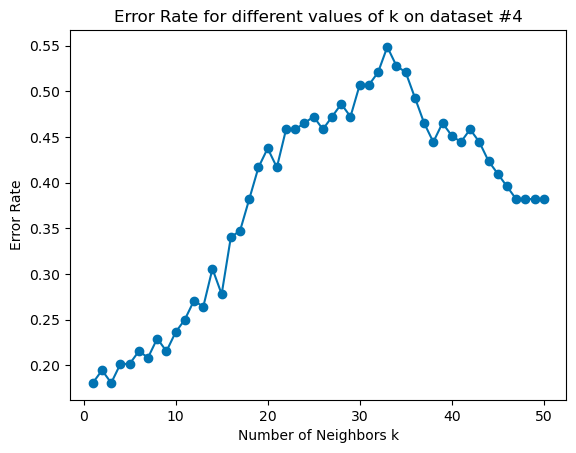

In [11]:
# Using df4 dataset, draw error rate curves for different values of k from 1 to 50

# Load dataset #2
X_d4, y_d4 = d4

# Splitting dataset for training and testing (pair for the training, impair for the testing)
X_train_d4, X_test_d4 = X_d4[::2], X_d4[1::2]
y_train_d4, y_test_d4 = y_d4[::2], y_d4[1::2]

# Initialize lists to store error rates
error_rates_d4 = []

# Loop over different values of k
k_values = list(range(1, 51)) 

# Initialize and train KNN class with different k
error_curve = ErrorCurve(k_range=k_values)
error_curve.fit_curve(X_train_d4, y_train_d4, X_test_d4, y_test_d4)

# Plotting the error rates against k values
plt.plot(k_values, error_curve.errors, marker='o')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Error Rate')
plt.title('Error Rate for different values of k on dataset #4')
plt.show()


<img src="questions/10.png" alt="question 10" width="800"/>

Erreur minimale pour n = 100 lorsque k = 1.
Erreur minimale pour n = 200 lorsque k = 1.
Erreur minimale pour n = 500 lorsque k = 3.
Erreur minimale pour n = 1000 lorsque k = 21.


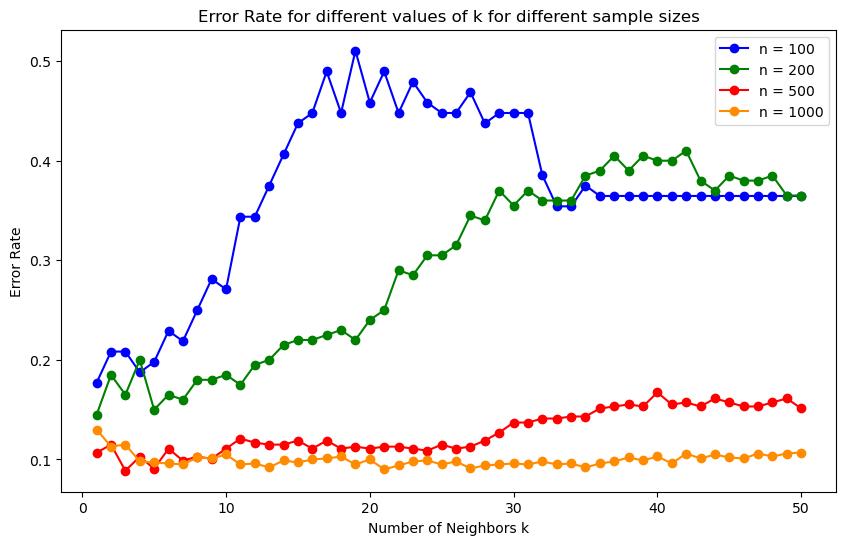

In [12]:
# Values of k to test and variation of sample size
n_values = [100, 200, 500, 1000]
k_values = list(range(1, 51))

# Creating plotsize
plt.figure(figsize=(10, 6))

# Loop over different values of n
for count, sample_size in enumerate(n_values) :
    # Generate the dataset for the current sample size
    X, y = rand_checkers(n1=sample_size, n2=sample_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5)

    # Calculate the error rates for the current sample size
    error_curve = ErrorCurve(k_range=k_values)
    error_curve.fit_curve(X_train,y_train,X_test,y_test)

    # Modify the color of the plot for each sample size
    color=['blue','green','red','darkorange']

    # Add a legend and title to the plot
    plt.plot(k_values, error_curve.errors, marker='o', label='n = ' + str(sample_size), color=color[count])
    plt.xlabel('Number of Neighbors k')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title("Error Rate for different values of k for different sample sizes")

    # Print the minimum error rate and the corresponding k value
    k_min_error = np.argmin(error_curve.errors) + 1
    print("Erreur minimale pour n = " + str(sample_size) + " lorsque k = " + str(k_min_error) + ".")

 $\underline{Commentaire}$ : Les meilleures valeurs de k ont été affichées précédemment. Elles dependent fortement de la taille de l'échantillon considéré.
 
 Plusieurs enseignements à tirer de ce graphique :  
1- L'erreur moyenne diminue plus la taille de l'échantillon est élevé car cela permet un entraintement avec un plus grand nombre de données ce qui donne des prédictions de meilleure qualité.  
   
2- L'augmentation de la valeur de k influence négativement les échantillons de taille faible (logiquement car pour de petits échantillon, tenir en compte un grand nombre de voisin force l'algorithme à aller piocher des valeurs dans d'autres labels surtout dans le cas présent avec la forme en damier).

3- L'augmentation de la valeur de k a une influence faible sur le taux d'erreur à partir d'un certain seuil (la valeur de l'erreur diminue globalement très peu à partir de k=7 pour les échantillons de taille 500 et 1000)

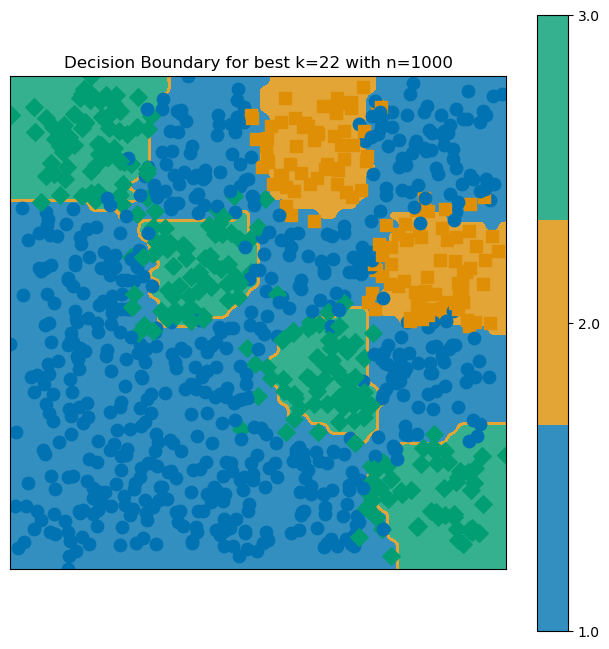

In [13]:
# Generate dataset #4 with n = 1000
X, y = rand_checkers(n1=1000, n2=1000)

# Split the dataset into training and test sets of equal size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=1000)

# ErrorCurve instance for k values from 1 to 50
error_curve = ErrorCurve(k_range=k_values)

# Fit the curve and calculate errors for n = 1000
error_curve.fit_curve(X_train, y_train, X_test, y_test)

# Find the k value with minimum error for n = 1000
k_min_error = np.argmin(error_curve.errors) + 1  # +1 because indexing starts at 0

# Initialize kNN with the best k value
best_knn = neighbors.KNeighborsClassifier(n_neighbors=k_min_error)
best_knn.fit(X_train, y_train)

# Visualize the data and the decision rule with frontiere_new
plt.figure(figsize=(8, 8))
decision_function = lambda x: best_knn.predict(x.reshape(1, -1))

frontiere_new(decision_function, X_train, y_train)

plt.title(f'Decision Boundary for best k={k_min_error} with n=1000')
plt.show()


<img src="questions/11.png" alt="question 11" width="800"/>

 $\underline{Commentaire}$ : Méthode des plus proches voisins  
   
Avantages :
- Interprétabilité/explicabilité : pour rappel, le machine learning souffre d'un grand défaut à savoir l'effet "black box" qui fait que les explications concernant une labellisation sont loin d'être évidentes. L'algorithme kNN est très intuitif à expliquer visuellement et cela peut être utile dans le cadre de la démarche d'explicabilité des résultats. 
- Possibilité de pondérer : la possibilité de pondérer les plus proches voisins selon la distance a du sens et permet de donner plus de poids aux voisins les plus proches. Cette méthode permet de diminuer l'effet potentiel de valeurs lointaines entrant dans le décompte des k plus proches voisins.
  
Inconvénients :
- Temps de calcul : cette méthode est couteuse pour de grands échantillons car il nous faut calculer la distance entre chaque nouveau point dont la prédiction est à effectuer avec l'ensemble des points utilisés pour l'entrainement.
- Passage à l'échelle : conséquence directe du temps de calcul peu efficient, le kNN semble peu scalable en raison de l'augmentation linéaire du temps de calcul avec l'augmentation du volume de données.
- Grande variabilité du choix de k selon la taille de l'échantillon : A travers les quelques exemples abordés, le choix d'un k optimal n'a rien d'évident. Trop grand, il risque de générer des frontières trop lisses et trop petit, il risque de générer une frontière de décision complexe sans sens particulier. Néanmoins et pour des échantillons suffisament grands, prendre une valeur de k entre 5 et 10 parait un bon compromis.

<img src="questions/12.png" alt="question 12" width="800"/>

In [14]:
from sklearn import datasets

# Import the digits dataset
digits = datasets.load_digits()
X, y = digits.data, digits.target

# Description of the dataset
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

 $\underline{Commentaire}$ : Les informations principales sont énoncées ci-dessus, la base de données est une banque d'images de chiffres de 8x8 pixels.  La valeur de chaque pixel représente l'intensité du noir.  
 L'objectif est la reconnaissance des chiffres pour leur attribuer une classe correspondante au chiffre.  


In [15]:
# Type of the dataset
for title, value in digits.items():
    print(title, type(value))

data <class 'numpy.ndarray'>
target <class 'numpy.ndarray'>
frame <class 'NoneType'>
feature_names <class 'list'>
target_names <class 'numpy.ndarray'>
images <class 'numpy.ndarray'>
DESCR <class 'str'>


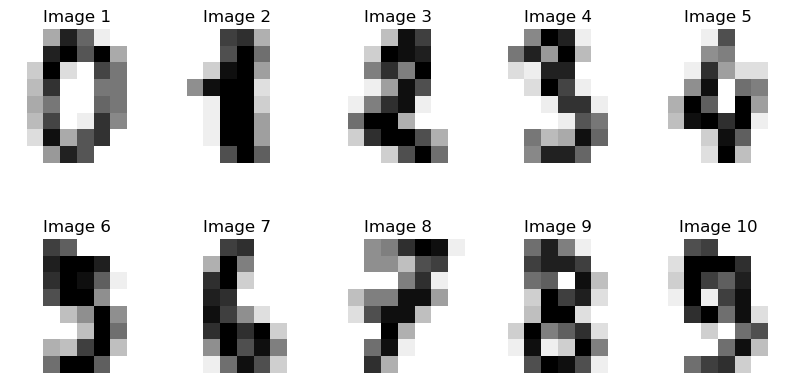

In [16]:
# Visualize the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Reshape the image to a 2D array of 8x8 pixels
    ax.imshow(digits.images[i], cmap='binary')
    # Remove the axes
    ax.set_axis_off()
    # Add the label to the plot
    ax.set_title(f"Image {i+1}")
plt.show()

In [17]:
# Example for the first image

print("Valeur de l'intensité pour l'image 1 : \n", digits.data[0], "\n Son label est ", digits.target[0])

Valeur de l'intensité pour l'image 1 : 
 [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 
 Son label est  0


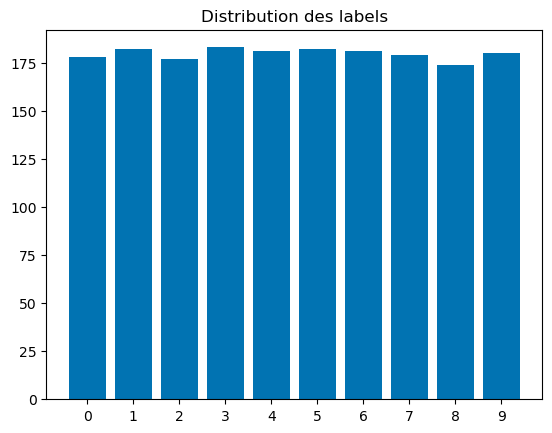

In [18]:
# Histogram for the label distribution using seaborn
plt.bar(range(10), np.bincount(digits.target))
plt.title("Distribution des labels")
plt.xticks(range(10))

plt.show()

In [25]:
# Cut the dataset into training and testing sets (50% for each)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=0.5, test_size=0.5)

# Initialize the kNN classifier with k=30
knn = KNeighborsClassifier(n_neighbors=30)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Predict on the test data
test_predictions = knn.predict(X_test)

# Calculate accuracy on test data and error rate
test_accuracy = accuracy_score(y_test, test_predictions)
test_error_rate = 1 - test_accuracy

print("Taux d'erreur pour k = 30 :", round(test_error_rate*100,1), "%")

Taux d'erreur pour k = 30 : 5.0 %


<img src="questions/13.png" alt="question 13" width="800"/>

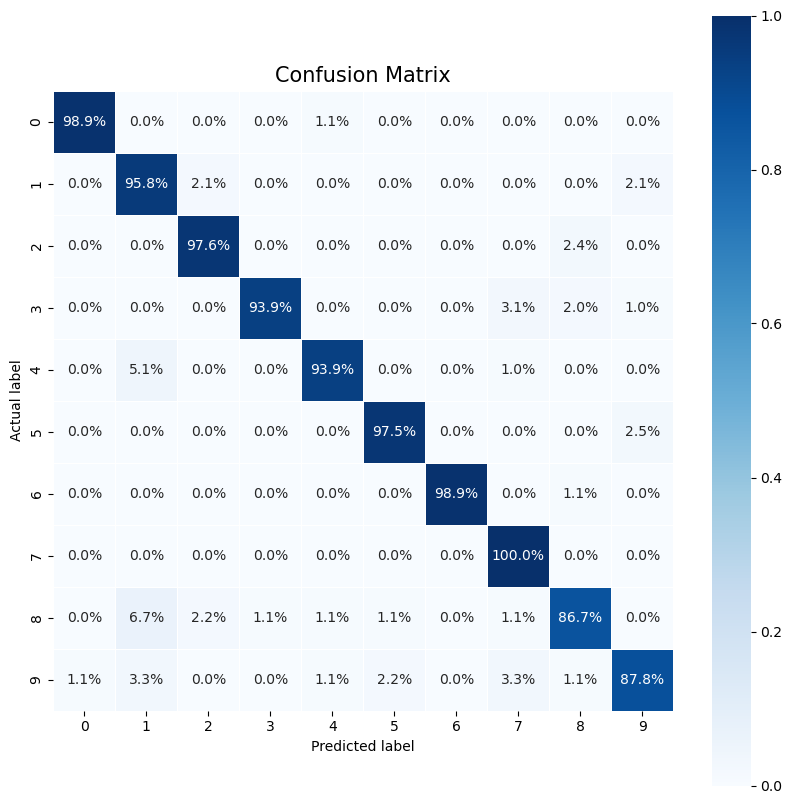

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Convert the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualisation of the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_percentage, annot=True, fmt=".1%", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()


 $\underline{Commentaire}$ : Confusions les plus fréquentes
 - Le 2 (valeur prédite) est confondu avec un 1 (valeur réelle)
 - Le 1 (valeur prédite) est confondu avec un 8 (valeur réelle) 
 - Le 1 (valeur prédite) est confondu avec un 4 (valeur réelle)  

(Les valeurs peuvent changer à chaque génération de données, les confusions citées sont les plus fréquentes)

<img src="questions/14.png" alt="question 14" width="800"/>

 $\underline{Commentaire}$ : Une méthode pour le choix de k consiste ici à utiliser la classe LOOCurve pour parcourir les valeurs de k et obtenir le score d'accuracy le plus elevé.

The best value of k is 1


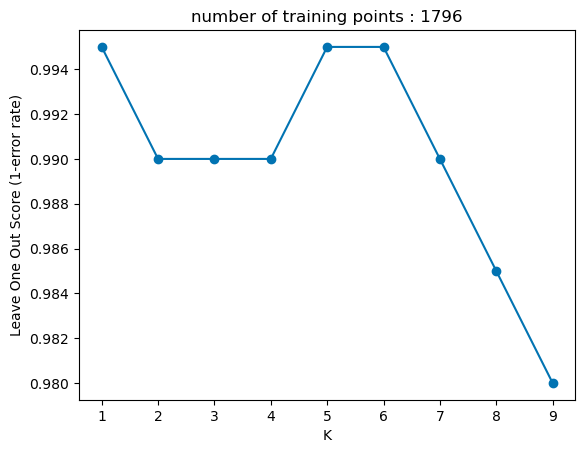

In [27]:
# Values of k to test
k_test = range(1, 10)
# Using the LOOCurve class
loo_curve = LOOCurve(k_range = k_test, weights = 'uniform')
loo_curve.fit_curve(X, y)
loo_curve.plot()
# Identifiez la valeur de k avec le score de validation croisée le plus élevé
best_k = k_test[np.argmax(loo_curve.cv_scores)]
print(f"The best value of k is {best_k}")



 $\underline{Commentaire}$ : La meilleure valeur de k est obtenue pour k = 1, il est inutile de tester k pour de plus grandes valeurs étant donnée la forme de la courbe avec un score qui décroit avec l'augmentation de la valeur de k.

The best value of k is 1


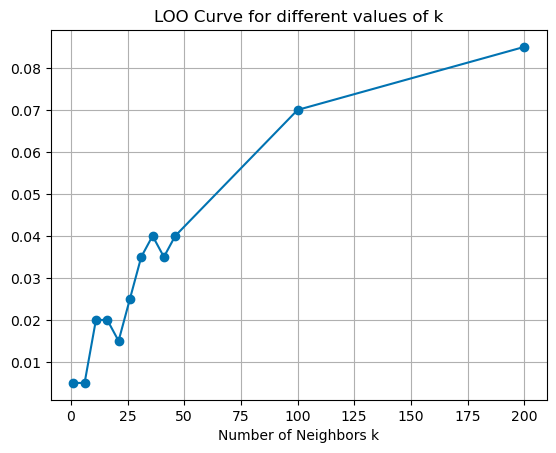

In [28]:
# Plotting the LOO curve for specific values of k
k_values = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]

# Identifiez la valeur de k avec le score de validation croisée le plus élevé
loo_curve = LOOCurve(k_range = k_values, weights = 'uniform')
loo_curve.fit_curve(X, y)

error = 1 - np.array(loo_curve.cv_scores)
plt.plot(k_values, error, marker='o')
plt.title("LOO Curve for different values of k")
plt.xlabel("Number of Neighbors k")
plt.grid(True)

best_k = k_values[np.argmax(loo_curve.cv_scores)]
print(f"The best value of k is {best_k}")

 $\underline{Commentaire}$ : La fonction ci-dessous donne l'erreur pour les différentes valeurs de k. On peut observer que l'erreur minimale est pour un proche voisin de 1 conformément à ce que nous avons énoncé précédemment.

### Aspect théorique

<img src="questions/15.png" alt="question 15" width="800"/>

**Question 15**

Rappel de la formule de Bayes : 

$P\{Y = +1 | X = x\} = \frac{P \{ X = x  \cap  Y = +1 \} }{P \{ X = x \}}$  
    
or $P \{ X = x  \cap  Y = +1 \} = P\{X = x | Y = +1 | \} \times P \{ Y = +1 \}$

ie $P\{Y = +1 | X = x\} = \frac{P \{ X = x | Y = +1 \} \times P \{ Y = +1 \}}{P \{ X = x \}}$

Injectons deux expressions pour se conformer aux notations données dans le problème :

- (1) Formule des probabilités totales :  
  $P \{ X = x \} = P \{ X = x | Y = +1 \} \times P \{ Y = +1 \} + P \{ X = x | Y = -1 \} \times P \{ Y = -1 \}$

- (2) $P \{ Y = -1 \} = 1 - P \{ Y = +1 \} $ 

La formule de Bayes donne l'expression suivante :  
  
$P\{Y = +1 | X = x\} = \frac{P \{ X = x | Y = +1 \} \times P \{ Y = +1 \}}{P \{ X = x | Y = +1 \} \times P \{ Y = +1 \} + P \{ X = x | Y = -1 \} \times (1 - P \{ Y = +1 \})}$

En reprenant les notations du TP, nous obtenons :

$\textcolor{red}{P\{Y = +1 | X = x\} = \frac{f_+ \ \pi_+}{f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)}}$ 

Avec un raisonnement similaire, nous obtenons pour $P\{Y = -1 | X = x\}$ :

$\textcolor{red}{P\{Y = -1 | X = x\} = \frac{f_- \ (1 - \pi_+)}{f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)}}$

**Question 16**

Expression des log-ratio :
  
$\log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x\}} \right) = \log \left( \frac{f_+ \ \pi_+ \ / \ [f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)]}{f_- \ (1 - \pi_+) \ / \ [f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)]} \right)$  

= $\log \left( \frac{f_+ \ \pi_+ }{f_- \ (1 - \pi_+) } \right)$  
  
= $\log \left( \frac{f_+}{f_-} \right) + \log(\pi_+) - \log(1 - \pi_+)$

Il nous reste à exprimer le premier terme en fonction des variables souhaitées :  
  
$\log \left( \frac{f_+}{f_-} \right) = \log \left( \frac{(2 \pi)^{-p/2} |\Sigma|^{-1/2} exp \left\{ -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) \right\}}{(2 \pi)^{-p/2} |\Sigma|^{-1/2} exp \left\{ -\frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-) \right\}} \right)$   
  
= $\log \left( \frac{exp \left\{ -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) \right\}}{exp \left\{ -\frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-) \right\}} \right)$

$= -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) + \frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-)$ 

$= - \frac{1}{2} \left( x^T \Sigma^{-1} x + \mu_+^T \Sigma^{-1} \mu_+ - 2 x^T \Sigma^{-1} \mu_+ - x^T \Sigma^{-1} x - \mu_-^T \Sigma^{-1} \mu_- + 2 x^T \Sigma^{-1} \mu_- \right)$

$= - \frac{1}{2} \left( \mu_+^T \Sigma^{-1} \mu_+ - 2 x^T \Sigma^{-1} \mu_+ - \mu_-^T \Sigma^{-1} \mu_- + 2 x^T \Sigma^{-1} \mu_- \right)$

$= - \frac{1}{2} \left( \mu_+^T \Sigma^{-1} \mu_+ - \mu_-^T \Sigma^{-1} \mu_- - 2 x^T \Sigma^{-1} (\mu_+ - \mu_-) \right)$



Expression finale :  

$\textcolor{red}{\log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x\}} \right) = - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + x^T \Sigma^{-1} (\mu_+ - \mu_-) + \log(\pi_+) - \log(1 - \pi_+)}$

**Question 17**

Il s'agit ici d'un cas binaire avec deux issues possibles (label $Y = 1$ ou label $Y = -1$).  
  
Nous avons donc pour un point $X$ : $Y = 1$ si $P\{Y = 1 | X = x\} > P\{Y = -1 | X = x \}$.  
  


$\Leftrightarrow \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x \}}  > 1$

$\Leftrightarrow \log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x \}} \right)  > 0$  
  
Nous injectons l'expression obtenue précédemment :  
  
$\Leftrightarrow - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + x^T \Sigma^{-1} (\mu_+ - \mu_-) + \log(\pi_+) - \log(1 - \pi_+) > 0$

$\Leftrightarrow x^T \Sigma^{-1} (\mu_+ - \mu_-)   > \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ - \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + \log(1 - \pi_+) - \log(\pi_+)$

Remplaçons $\pi_+$ et $\pi_-$ par les expressions des estimateurs sans biais :  
  
$\textcolor{red}{\Leftrightarrow x^T \hat{\Sigma}^{-1} (\hat{\mu}_+ - \hat{\mu}_-)   > \frac{1}{2} \hat{\mu}_+^T \Sigma^{-1} \hat{\mu}_+ - \frac{1}{2} \hat{\mu}_-^T \hat{\Sigma}^{-1} \hat{\mu}_- + \log(1 - m/n) - \log(m/n)}$

Nous obtenons le classifieur demandé.

### Mise en oeuvre

<img src="questions/18.png" alt="question 18" width="800"/>

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class LDAClassifier(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        # Ensure that the classes are 1 and -1
        classes = np.unique(y)
        if set(classes) != {-1, 1}:
            raise ValueError("Class labels must be 1 or -1.")

        # Calculating the prior probabilities
        n_total = len(y)
        n_label_1 = np.sum(y == 1)
        pi_hat_p = n_label_1 / n_total

        # Splitting the dataset into two parts
        X_label_pos = X[y == 1, :]
        X_label_neg = X[y == -1, :]

        # Calculating the means
        mu_hat_pos = np.mean(X_label_pos, axis=0)
        mu_hat_neg = np.mean(X_label_neg, axis=0)

        # Calculating the covariance matrices
        Sigma_hat_pos = (X_label_pos - mu_hat_pos).T @ (X_label_pos - mu_hat_pos) / (n_label_1 - 1)
        Sigma_hat_neg = (X_label_neg - mu_hat_neg).T @ (X_label_neg - mu_hat_neg) / (n_total - n_label_1 - 1)

        # Calculating the pooled covariance matrix
        Sigma_hat = (Sigma_hat_pos * (n_label_1 - 1) + Sigma_hat_neg * (n_total - n_label_1 - 1)) / (n_total - 2)

        # Calculating the inverse of the covariance matrix
        inv_Sigma_hat = np.linalg.inv(Sigma_hat)

        # Calculating the coefficients
        self.coef_ = inv_Sigma_hat @ (mu_hat_pos - mu_hat_neg)
        
        # Log prior odds for two-class case with classes 1 and -1
        log_prior_odds = np.log(pi_hat_p / (1 - pi_hat_p))
        
        # Calculating the intercept
        self.intercept_ = -0.5 * (mu_hat_pos @ inv_Sigma_hat @ mu_hat_pos - mu_hat_neg @ inv_Sigma_hat @ mu_hat_neg) + log_prior_odds
        return self
    
    def predict(self, X):
        # Using the decision rule for binary classification with classes 1 and -1
        decision_scores = X @ self.coef_ + self.intercept_
        return np.where(decision_scores > 0, 1, -1)


<img src="questions/19.png" alt="question 19" width="800"/>

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a binary classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.3, 0.7], flip_y=0, random_state=42)

# Transform labels from {0, 1} to {-1, 1}
y[y == 0] = -1

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.1, test_size=0.9, random_state=42)

# Train LDAClassifier
lda_custom = LDAClassifier()
lda_custom.fit(X_train, y_train)
predictions_custom = lda_custom.predict(X_val)

# Train LinearDiscriminantAnalysis from sklearn
lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X_train, y_train)
predictions_sklearn = lda_sklearn.predict(X_val)

# Calculate error rates
error_custom = 1 - accuracy_score(y_val, predictions_custom)
error_sklearn = 1 - accuracy_score(y_val, predictions_sklearn)

# Compare predictions
Similarities = np.sum(predictions_custom == predictions_sklearn)

print(f"Error rate - LDAClassifier: {error_custom:.2f}")
print(f"Error rate - LinearDiscriminantAnalysis: {error_sklearn:.2f}")
print(f"Percentage of similarities for predictions between the two classes : {Similarities/len(y_val)*100} %")

Error rate - LDAClassifier: 0.09
Error rate - LinearDiscriminantAnalysis: 0.09
Percentage of similarities for predictions between the two classes : 100.0 %


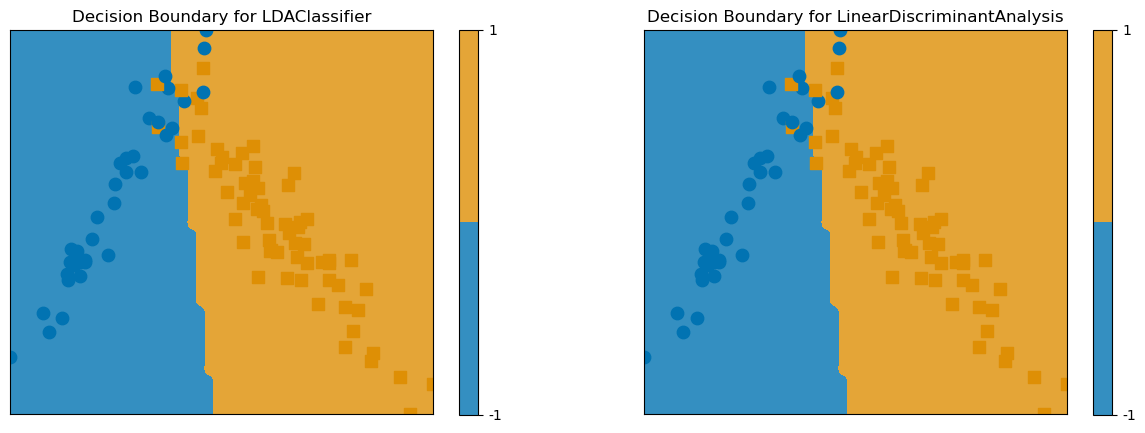

In [31]:
# Subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the decision boundary for LDAClassifier
plt.sca(axes[0])
decision_function = lambda x: lda_custom.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_train, y_train)
plt.title('Decision Boundary for LDAClassifier')

# Plot the decision boundary for LinearDiscriminantAnalysis
plt.sca(axes[1])
decision_function = lambda x: lda_sklearn.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_train, y_train)
plt.title('Decision Boundary for LinearDiscriminantAnalysis')

plt.show()

<img src="questions/20.png" alt="question 20" width="800"/>

In [32]:
# Load dataset #1
X_d1, y_d1 = d1

# Splitting dataset for training and testing (pair for the training, impair for the testing)
X_train_d1, X_test_d1 = X_d1[::2], X_d1[1::2]
y_train_d1, y_test_d1 = y_d1[::2], y_d1[1::2]

# Load dataset #3
X_d3, y_d3 = d3

# Splitting dataset for training and testing (pair for the training, impair for the testing)
X_train_d3, X_test_d3 = X_d3[::2], X_d3[1::2]
y_train_d3, y_test_d3 = y_d3[::2], y_d3[1::2]

# Initialize LDAClassifier
lda = LDAClassifier()

# Train, predict, accuracy for dataset #1
lda.fit(X_train_d1, y_train_d1)
predictions_d1 = lda.predict(X_test_d1)
accuracy_d1 = accuracy_score(y_test_d1, predictions_d1)

# Train, predict, accuracy for dataset #3
lda.fit(X_train_d3, y_train_d3)
predictions_d3 = lda.predict(X_test_d3)
accuracy_d3 = accuracy_score(y_test_d3, predictions_d3)

# Print accuracies
print(f"Accuracy on dataset #1: {accuracy_d1}")
print(f"Accuracy on dataset #3: {accuracy_d3}")

Accuracy on dataset #1: 0.9
Accuracy on dataset #3: 0.56


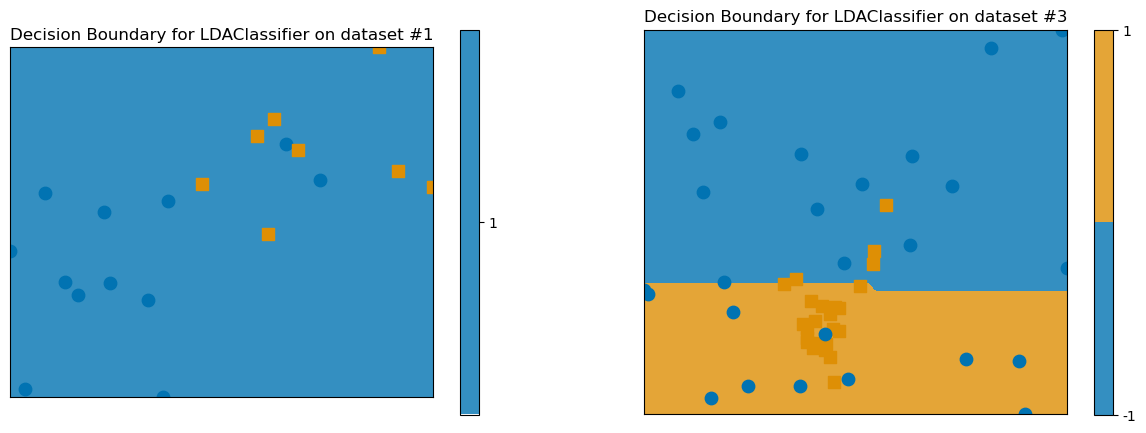

In [33]:
# Visualize the decision boundaries for dataset #1 using frontiere_new

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the decision boundary for LDAClassifier on dataset #1
plt.sca(axes[0])
decision_function = lambda x: lda.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_train_d1, y_train_d1)
plt.title('Decision Boundary for LDAClassifier on dataset #1')

# Plot the decision boundary for LDAClassifier on dataset #3
plt.sca(axes[1])
decision_function = lambda x: lda.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_train_d3, y_train_d3)
plt.title('Decision Boundary for LDAClassifier on dataset #3')

plt.show()

 $\underline{Commentaire}$ : Les résultats sont logiquement bons pour le dataset #1 puisque l'échantillon est créé sur la base de deux fonctions gaussiennes avec des moyennes différentes et des variances égales. Le classifieur créé trace donc une droite de séparation qui parvient à effectuer le travail de classification avec une bonne précision.  
 En revanche, les échantillons pour le dataset #3 sont basés sur une "distribution clown" créant des points en forme parabolique (premier type de classe) et des points à l'intérieur de la parabole (deuxième type de classe). Il est évident qu'une droite de séparation ne peut pas parvenir à classer ces échantillons correctement.  
  
L'efficacité du LDAClassifier est mauvaise pour le jeu de donnée 3 et bonne pour le jeu de données 1.

### Méthode discriminative avec régression logistique

<img src="questions/21.png" alt="question 21" width="800"/>

In [34]:
from sklearn import linear_model

# Creating dataset #1 with an unbalanced dataset
X_d1, y_d1 = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],sigmas2=[0.9, 0.9])

# Apply logistic regression on dataset #1
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_d1, y_d1)
predictions_d1_log = log_reg.predict(X_d1)

# Apply LDAClassifier on dataset #1
lda = LDAClassifier()
lda.fit(X_d1, y_d1)
predictions_d1_LDA = lda.predict(X_d1)

# Calculate accuracy on dataset #1 for logistic regression
accuracy_logistic = accuracy_score(y_d1, predictions_d1_log)
print(f"Accuracy on dataset #1 for logistic regression : {accuracy_logistic*100:.2f}%")

# Calculate accuracy on dataset #1 for LDAClassifier
accuracy_LDA = accuracy_score(y_d1, predictions_d1_LDA)
print(f"Accuracy on dataset #1 for LDA : {accuracy_LDA*100:.2f}%")

Accuracy on dataset #1 for logistic regression : 94.00%
Accuracy on dataset #1 for LDA : 94.00%


In [35]:
from sklearn import linear_model

# Creating dataset #1 with an unbalanced dataset
X_d1, y_d1 = rand_bi_gauss(n1=20, n2=180, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],sigmas2=[0.9, 0.9])

# Apply logistic regression on dataset #1
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_d1, y_d1)
predictions_d1_log = log_reg.predict(X_d1)

# Apply LDAClassifier on dataset #1
lda = LDAClassifier()
lda.fit(X_d1, y_d1)
predictions_d1_LDA = lda.predict(X_d1)

# Calculate accuracy on dataset #1 for logistic regression
accuracy_logistic = accuracy_score(y_d1, predictions_d1_log)
print(f"Accuracy on dataset #1 for logistic regression : {accuracy_logistic*100:.2f}%")

# Calculate accuracy on dataset #1 for LDAClassifier
accuracy_LDA = accuracy_score(y_d1, predictions_d1_LDA)
print(f"Accuracy on dataset #1 for LDA : {accuracy_LDA*100:.2f}%")

Accuracy on dataset #1 for logistic regression : 98.50%
Accuracy on dataset #1 for LDA : 98.00%


 $\underline{Commentaire}$ : Les erreurs obtenues sont similaires entre les deux modèles dans les cas avec des classes équilibrées et déséquilibrées.

<img src="questions/22.png" alt="question 22" width="800"/>

 $\underline{Commentaire}$ : 
 - coef_ : donne l'importance de chaque variable dans le calcul de la décision du modèle. Une valeur faible signifie qu'une variable (feature) a peu d'influence sur le résultat d'une labélisation et une valeur élevée signifie qu'une variable a une grande importance dans le résultat d'une labelisation.
 - intercept_ : terme constant dans l'équation liée à la frontière de décision qui représente le point où l'hyperplan de décision croise l'axe des ordonnées.


<img src="questions/23.png" alt="question 23" width="800"/>

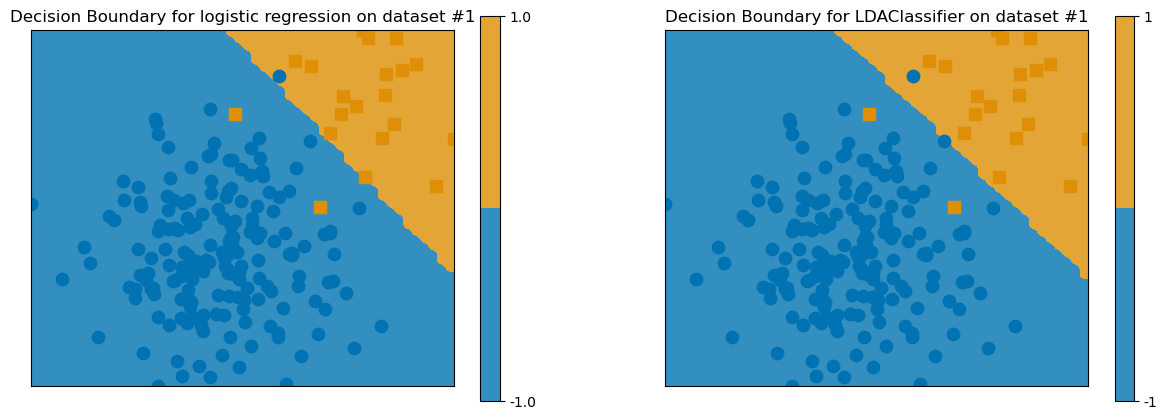

In [36]:
# Visualize the decision boundary for dataset #1 using frontiere_new
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the decision boundary for logistic regression on dataset #1
plt.sca(axes[0])
decision_function = lambda x: log_reg.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_d1, y_d1)
plt.title('Decision Boundary for logistic regression on dataset #1')

# Plot the decision boundary for LDAClassifier on dataset #1
plt.sca(axes[1])
decision_function = lambda x: lda.predict(x.reshape(1, -1))
frontiere_new(decision_function, X_d1, y_d1)
plt.title('Decision Boundary for LDAClassifier on dataset #1')

plt.show()

<img src="questions/24.png" alt="question 24" width="800"/>

In [37]:
# Load the digits dataset
digits = datasets.load_digits()
X, y = digits.data, digits.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=42)

# Apply logistic regression
log_reg = linear_model.LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)
predictions_log = log_reg.predict(X_test)

# Error rate for logistic regression
error_log = 1 - accuracy_score(y_test, predictions_log)
print(f"Error rate for logistic regression: {error_log*100:.2f}%")

Error rate for logistic regression: 4.00%


 $\underline{Commentaire}$ : Nous obtenons de bons résultats avec le jeu de données DIGITS en utilisant la classification par régression logistique de sklearn. Un modèle simple permet donc d'obtenir une précision élevée dans ce cas.